In [1]:
from ray import Reader
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandasql import sqldf
sql = lambda q: sqldf(q, globals())

import glob

In [2]:
def load_files(glob_pattern):
    df_data = pd.DataFrame()
    files = glob.glob(glob_pattern)
    for file in files:
        df_data = df_data.append(pd.read_csv(file))
    return df_data

In [3]:
df_replay = load_files("output/*/replay.csv")
df_player = load_files("output/*/players.csv")
df_elimination = load_files("output/*/eliminations.csv")

# Matches Played

In [4]:
df_player_matches_played = sql("""
    select file, player_name, sum(matches_played) matches_played 
    from df_player
    group by file, player_name
    order by matches_played
    """)

In [5]:
pd.DataFrame(df_player_matches_played['matches_played'].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
matches_played,915.0,2910.310383,2403.306457,2.0,922.0,2316.0,4356.0,13086.0


/Users/peter/anaconda/envs/fn/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


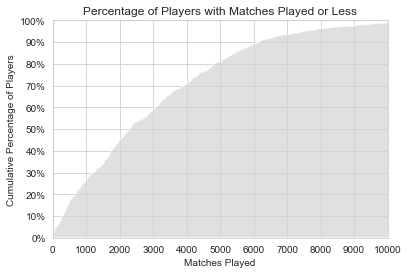

In [6]:
sns.set_style("whitegrid")
x = df_player_matches_played['matches_played']
ax = sns.distplot(x,  bins=500, 
                  hist_kws={'cumulative': True, "alpha": 0.7, "color": "lightgrey", "histtype": "stepfilled"},
                  kde_kws={"alpha":0})
ax.set_title("Percentage of Players with Matches Played or Less")
ax.set_xlim(1, 10000)
ax.set_ylim(0, 1)
ax.set(xlabel='Matches Played', ylabel='Cumulative Percentage of Players')
plt.setp(ax,yticks=[x/10 for x in range(11)])
plt.setp(ax,xticks=[x*1000 for x in range(11)]) 
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
pass

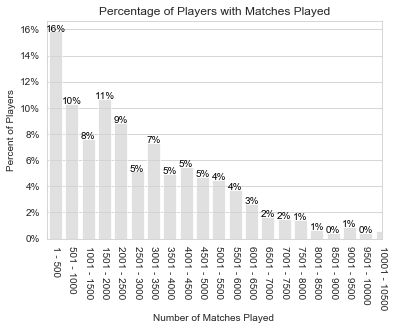

In [7]:
df_matcheds_played_bands = sql("""
    select band, cast(band*500+1 as text) || ' - ' || cast((band+1)*500 as text) band_name, count(*) value
    from (select matches_played/500 band from df_player_matches_played)
    group by band
    order by band
    """)
sns.set_style("whitegrid")
df_matcheds_played_bands['value_perc'] = df_matcheds_played_bands['value']/len(df_player_matches_played)
ax = sns.barplot(df_matcheds_played_bands['band'], df_matcheds_played_bands['value_perc'], color="lightgrey", **{'alpha':0.7})
ax.set_title("Percentage of Players with Matches Played")
ax.set_xlim(-0.5, 20)
ax.set(xlabel='Number of Matches Played ', ylabel='Percent of Players')
ax.set_xticklabels(labels=df_matcheds_played_bands['band_name'], rotation=270)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

for index, row in df_matcheds_played_bands[0:20].iterrows():
    ax.text(row.band,row.value_perc, str(int(round(row.value_perc*100, 0))) + '%', color='black', ha="center")
pass

# KD Rate

In [8]:
df_player_kd_rate = sql("""
    select file, player_name, max(kd_rate) kd_rate 
    from df_player
    group by file, player_name
    order by kd_rate
    """)

In [9]:
pd.DataFrame(df_player_kd_rate['kd_rate'].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
kd_rate,915.0,1.008044,0.847146,0.0,0.4,0.79,1.35,7.9


/Users/peter/anaconda/envs/fn/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


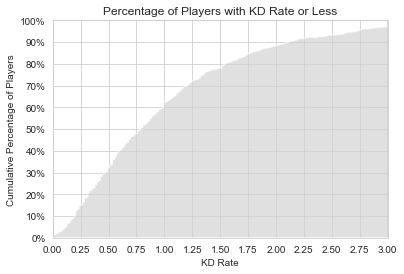

In [10]:
sns.set_style("whitegrid")
x = df_player_kd_rate['kd_rate']
ax = sns.distplot(x,  bins=500, 
                  hist_kws={'cumulative': True, "alpha": 0.7, "color": "lightgrey", "histtype": "stepfilled"},
                  kde_kws={"alpha":0})
ax.set_title("Percentage of Players with KD Rate or Less")
ax.set_xlim(0, 3)
ax.set_ylim(0, 1)
ax.set(xlabel='KD Rate', ylabel='Cumulative Percentage of Players')
plt.setp(ax,xticks=[x/4 for x in range(13)])
plt.setp(ax,yticks=[x/10 for x in range(11)])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
pass

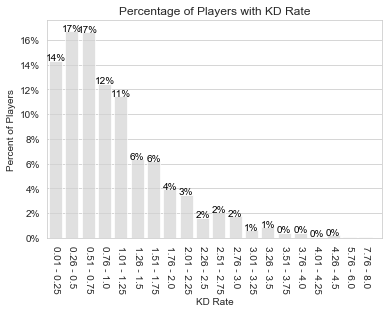

In [11]:
df_player_kd_rate_bands = sql("""
    select band, cast(band*0.25+0.01 as text) || ' - ' || cast((band+1)*0.25 as text) band_name, count(*) value
    from (select cast(kd_rate/0.25 as int) band from df_player_kd_rate)
    group by band
    order by band
    """)
sns.set_style("whitegrid")
df_player_kd_rate_bands['value_perc'] = df_player_kd_rate_bands['value']/len(df_player_matches_played)
ax = sns.barplot(df_player_kd_rate_bands['band'], df_player_kd_rate_bands['value_perc'], color="lightgrey", **{'alpha':0.7})
ax.set_title("Percentage of Players with KD Rate")
ax.set_xlim(-0.5, 20)
ax.set(xlabel='KD Rate', ylabel='Percent of Players')
ax.set_xticklabels(labels=df_player_kd_rate_bands['band_name'], rotation=270)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

for index, row in df_player_kd_rate_bands[0:18].iterrows():
    ax.text(row.band,row.value_perc, str(int(round(row.value_perc*100, 0))) + '%', color='black', ha="center")
pass

# KD Rate vs Matches Played

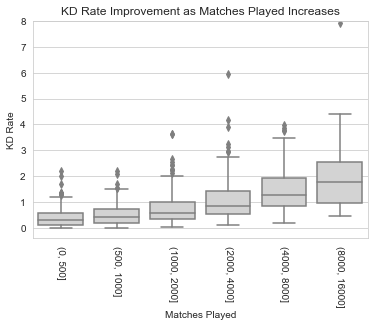

In [40]:
df_kd_vs_matches = df_player_matches_played.merge(df_player_kd_rate, on=["file", "player_name"])

bins = [0] + [((2**x))*500 for x in range(6)]
df_kd_vs_matches['mp_bins'] = pd.cut(df_kd_vs_matches['matches_played'], bins=bins)

sns.set_style("whitegrid")
ax = sns.boxplot(x="mp_bins", y="kd_rate", data=df_kd_vs_matches, color="lightgrey")
ax.set_title("KD Rate Improvement as Matches Played Increases")
ax.set(xlabel='Matches Played', ylabel='KD Rate')
ax.set_xticklabels(labels=df_kd_vs_matches['mp_bins'].cat.categories.values, rotation=270)
ax.set_ylim(None, 8)
pass

# KD vs Players Remaining

In [29]:
pd.DataFrame(df_elimination['seconds'].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
seconds,1016.0,327.040669,281.470435,48.3,128.34675,209.082,457.48,1425.803


In [51]:
df_players_left_bins = pd.DataFrame()
for t in [x*240 for x in range(6)]:
    df_players_left_bins = df_players_left_bins.append(
        sql("""
            select player.file, player.player_name, kd_rate, matches_played, """ + str(t) + """ seconds_bin
            from df_player_kd_rate,
                 df_player_matches_played,
                 (select file, eliminated player_name from df_elimination union select file, eliminator from df_elimination) as player
            where not exists (select 1 
                              from df_elimination
                              where player.file = df_elimination.file 
                              and player.player_name = df_elimination.eliminated
                              and df_elimination.seconds < """ + str(t) + """)
            and player.file = df_player_kd_rate.file
            and player.player_name = df_player_kd_rate.player_name
            and player.file = df_player_matches_played.file
            and player.player_name = df_player_matches_played.player_name
            """)
        )

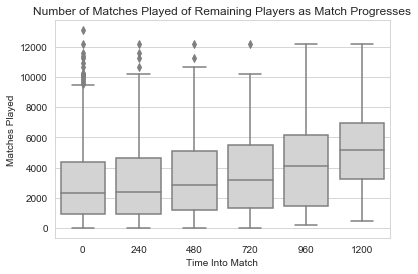

In [52]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="seconds_bin", y="matches_played", data=df_players_left_bins, color="lightgrey")
ax.set_title("Number of Matches Played of Remaining Players as Match Progresses")
ax.set(xlabel='Time Into Match', ylabel='Matches Played')
pass

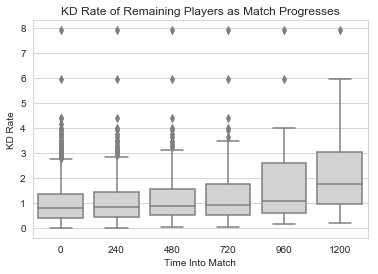

In [53]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="seconds_bin", y="kd_rate", data=df_players_left_bins, color="lightgrey")
ax.set_title("KD Rate of Remaining Players as Match Progresses")
ax.set(xlabel='Time Into Match', ylabel='KD Rate')
pass

In [21]:
df_players_left_count = pd.DataFrame()
for t in [x*20 for x in range(72)]:
    df_players_left_count = df_players_left_count.append(
        # Save this for the number of players query
        sql("""
            select file, count(*) value, """ + str(t) + """ seconds 
            from (select file, eliminated player_name from df_elimination union select file, eliminator from df_elimination) player
            where not exists (select 1 
                              from df_elimination
                              where player.file = df_elimination.file 
                              and player.player_name = df_elimination.eliminated
                              and df_elimination.seconds < """ + str(t) + """)
            group by file
            """)
    )

/Users/peter/anaconda/envs/fn/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


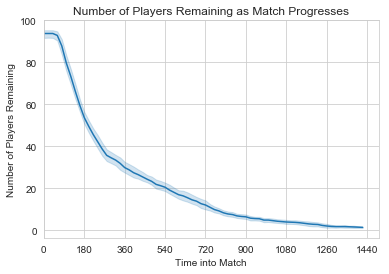

In [54]:
ax = sns.lineplot(x="seconds", y="value", data=df_players_left_count)
ax.set_title("Number of Players Remaining as Match Progresses")
ax.set(xlabel='Time into Match', ylabel='Number of Players Remaining')
ax.set_xlim(0, None)
plt.setp(ax,xticks=[x*180 for x in range(9)]) 
pass

# Kills

In [24]:
df_player_kills = sql("""
    select file, player_name, sum(kills) kills 
    from df_player
    group by file, player_name
    order by kills
    """)

In [25]:
pd.DataFrame(df_player_kills['kills'].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
kills,915.0,3533.67541,5174.590064,0.0,383.5,1627.0,4571.5,67485.0


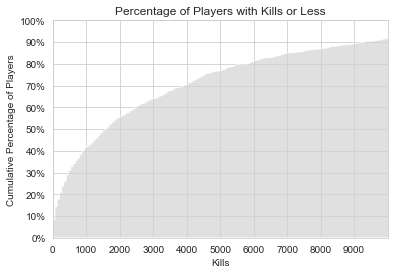

In [38]:
sns.set_style("whitegrid")
x = df_player_kills['kills']
ax = sns.distplot(x,  bins=1000, 
                  hist_kws={'cumulative': True, "alpha": 0.7, "color": "lightgrey", "histtype": "stepfilled"},
                  kde_kws={"alpha":0})
ax.set_title("Percentage of Players with Kills or Less")
ax.set_xlim(1, 10000)
ax.set_ylim(0, 1)
ax.set(xlabel='Kills', ylabel='Cumulative Percentage of Players')
plt.setp(ax,xticks=[x*1000 for x in range(10)]) 
plt.setp(ax,yticks=[x/10 for x in range(11)])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
pass

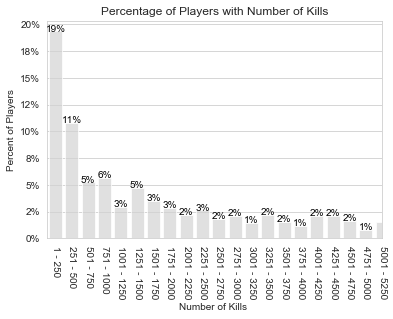

In [27]:
df_player_kills_bands = sql("""
    select band, cast(band*250+1 as text) || ' - ' || cast((band+1)*250 as text) band_name, count(*) value
    from (select kills/250 band from df_player_kills)
    group by band
    order by band
    """)
sns.set_style("whitegrid")
df_player_kills_bands['value_perc'] = df_player_kills_bands['value']/len(df_player_matches_played)
ax = sns.barplot(df_player_kills_bands['band'], df_player_kills_bands['value_perc'], color="lightgrey", **{'alpha':0.7})
ax.set_title("Percentage of Players with Number of Kills")
ax.set_xlim(-0.5, 20)
ax.set(xlabel='Number of Kills ', ylabel='Percent of Players')
ax.set_xticklabels(labels=df_player_kills_bands['band_name'], rotation=270)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

for index, row in df_player_kills_bands[0:20].iterrows():
    ax.text(row.band,row.value_perc, str(int(round(row.value_perc*100, 0))) + '%', color='black', ha="center")
pass